##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024
### TP1 - Recherche de documents avec une métrique de similarité


## Identification de l'équipe:

### Groupe de laboratoire: 3

### Equipe numéro : 10

### Membres:

- Mohamed Ali Lajnef / 2404991 (33.3%, Travail sur la partie 2.1 et 2.2)
- Mathis Nguyen / 2409535 (33.3%, Travail sur la partie 2.2 et 2.3)
- Einstein Franck Tiomo Epongo / 2093771 (33.3%, Travail sur la partie 3)

La partie 1 a été faite en commun.

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## Mise en place

### Objectif du TP

La recherche d'information est le processus d'accès aux données, généralement des documents ou d'autres données non structurées, à partir d'une requête. Dans ce TP, vous aurez en entrée une requête textuelle sous forme d'affirmation. Il faudra retrouver dans un corpus de littérature scientifique les documents pertinents qui justifient ou infirment la véracité de cette affirmation. Vous utiliserez des modèles vectoriels et des métriques de similarité pour cette tâche.

### Jeux de données

Dans ce TP, vous utiliserez le jeu de données dans le répertoire _data_. Il s'agit d'un ensemble de données comprenant 809 affirmations rédigées par des experts et 5183 documents de références pour ces affirmations. Ces documents contiennent des phrases qui confirment ou infirment (contredisent) les affirmations. L'objectif est donc de trouver un document pertinent, c'est-à-dire contenant la ou les phrases qui permettent d'évaluer une affirmation donnée en entrée en utilisant une similarité sémantique. 

Le jeu de données comprend :

1. Un corpus (_corpus.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'doc_id' : permet d'identifier le document en entrée
    - 'title' : donne le titre du document
    - 'abstract': est le résumé du document
    - 'structured': indique si le document est structuré ou pas

2. Un ensemble d'affirmations (_claims.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'id' : identifie l'affirmation.
    - 'claim' : est l'affirmation en tant que telle.
    - 'evidence' : précise quelles phrases du document sont pertinentes pour l'affirmation. Chaque phrase est accompagnée d'une étiquette de véracité (confirm/contradict) pour indiquer si la phrase confirme ou contredit l'affirmation.  
    - 'cited_doc_ids' : indique les identifiants des documents cités.



Dans _claims.jsonl_, seuls les identifiants des documents sont renseignés. Pour avoir les détails d'un document tel que le titre ("title") et le résumé ("abstract"), il faudra consulter le fichier _corpus.jsonl_. 

Voici un exemple :

- **Affirmation (claim)** : Consumption of whole fruits increases the risk of type 2 diabetes.
- **Cited document(s) ID(s)** : 1974176
- **Evidence (sentence in the document containing the proof)** : [{'sentences': [11], 'label': 'CONTRADICT'}]

  Ici [11] constitue le numéro de la phrase qui contredit l'affirmation.

- **Cited document(s) title(s)** : Fruit consumption and risk of type 2 diabetes: results from three prospective longitudinal cohort studies
- **Cited document(s) abstract(s) (list of sentences)** : 
    - [0] 'OBJECTIVE To determine whether individual fruits are differentially associated with risk of type 2 diabetes.\n'
    - [1] 'DESIGN Prospective longitudinal cohort study.'
    - ...
    - [10] 'CONCLUSION Our findings suggest the presence of heterogeneity in the associations between individual fruit consumption and risk of type 2 diabetes.'
    - [11] 'Greater consumption of specific whole fruits, particularly blueberries, grapes, and apples, is significantly associated with a lower risk of type 2 diabetes, whereas greater consumption of fruit juice is associated with a higher risk.'

Le champ "evidence" indique la phrase au niveau du résumé du document qui confirme ou infirme l'affirmation, d'où le numéro de la phrase et le label qui y sont renseignés. Dans le cas particulier de l'exemple ci-dessus, on voit bien que la onzième phrase du résumé du document est la plus pertinente pour l'affirmation et qu'elle la contredit, ce qui explique le label "CONTRADICT" dans "evidence". Cependant, dans le cadre de ce TP, on ne s'intéresse qu'à la présence de cette phrase pertinente dans le document, donc on ne considérera pas cette colonne "evidence" dans la suite du TP.

### Librairies permises
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- PowerLaw
- Matplotlib
- TQDM
- BM25
- Pour toute autre librairie, demandez à votre chargé de laboratoire

## Étapes du TP
A partir du notebook _INF8460_A24_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

In [45]:
# Lien vers les fichiers à utiliser
# Ne pas modifier

PATH = 'data/ai2_data/'

In [46]:
# !pip install rank_bm25 
# !pip install powerlaw

In [47]:
# Import des librairies

import numpy as np
import pandas as pd
import powerlaw
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

In [48]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Traitement des données (15 points)
Vous allez effectuer une analyse afin d'avoir une idée claire des données que vous aurez à manipuler.

#### 1.1 Chargement des données (2 points)

##### 1.1.1 Chargement et affichage des données (1 point)

Chargez les données '_claims.jsonl_' et '_corpus.jsonl_' puis affichez-les dans des dataframes en utilisant panda.

In [49]:
df_claims = pd.read_json(PATH+'/claims.jsonl', lines=True)
df_corpus = pd.read_json(PATH+'/corpus.jsonl', lines=True)

##### 1.1.2 Statistique sur les évidences (1 point)

Calculez les pourcentages d'apparition de chaque label des évidences dans "_df_claims_" (CONTRADICT ou SUPPORT). Pour rappel les évidences sont les extraits pertinents des résumés qui supportent ou contredisent les affirmations. 

In [50]:
# On calcule les pourcentages des labels present dans evidence

contradict_count = 0
support_count = 0

for id, claim in df_claims.iterrows(): # for each claim
    for doc_id, list_sentences in claim['evidence'].items(): #for each cited document
        for sentences in list_sentences: # for each sentences
            if sentences['label'] == 'CONTRADICT': 
                contradict_count += 1
            elif sentences['label'] == 'SUPPORT':
                support_count += 1

total_labels = contradict_count + support_count

contradict_percentage = (contradict_count / total_labels) * 100
support_percentage = (support_count / total_labels) * 100

print(f"CONTRADICT: {contradict_percentage:.2f}%")
print(f"SUPPORT: {support_percentage:.2f}%")

CONTRADICT: 35.63%
SUPPORT: 64.37%


> Réponse attendue:
> 
> CONTRADICT: 35.63%
> 
> SUPPORT: 64.37%

#### 1.2 Analyse statistique des données (7 points)

Nous allons faire une suite de transformations sur les données pour les rendre plus faciles à manipuler.

##### 1.2.1 Implémentation de la fonction "_list_to_string_" 

Nous mettons à votre disposition la fonction "_list_to_string_" qui transforme une liste de phrases en un texte en les concaténant et enlèvant tous les caractères de nouvelle ligne (`\n`) pour s'assurer que nous avons un texte complet. 

In [51]:
# On transforme la liste de phrases en un texte
def list_to_string(x):
    if isinstance(x, list):
        return ' '.join(str(i).replace("\n","").replace("  "," ") for i in x)  # Enlève les caractère de retour à la ligne et convertit les éléments de la liste en chaînes et les joint
    return str(x)

##### 1.2.2 Utilisation de la fonction "_list_to_string_" 

Appliquons cette fonction "_list_to_string_" aux colonnes "_title_" et "abstract" du dataframe "_df_corpus_".

In [52]:
# On applique la fonction aux colonnes "title" et "abstract"
df_corpus['title']    = df_corpus['title'].apply(list_to_string)
df_corpus['abstract'] = df_corpus['abstract'].apply(list_to_string)


##### 1.2.3 Ajout de la colonne "_text_" dans "df_corpus"


Ajoutons maintenant une colonne "_text_" qui est la concaténation du titre ("_title_") et du résumé ("_abstract_") au niveau du dataframe "df_corpus".

In [53]:
# On concatene les textes dans "title" et "abstract" pour ajouter la colonne text
df_corpus['text'] = df_corpus['title'] + " " + df_corpus['abstract']

##### 1.2.4 Ajout de colonnes dans "_df_claims_" (1 point)

Ajoutez les colonnes "_claim_length_" et "_num_cited_doc_" qui donnent, pour chaque affirmation, le nombre de mots dans la colonne "_claim_" et le nombre de documents cités au niveau de la colonne "_cited_doc_ids_" pour le dataframe "_df_claims_". Vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [54]:
# On ajoute les colonnes claim_length et num_cited_doc

df_claims['claim_length'] = df_claims['claim'].apply(lambda x: len(x.split()))
df_claims['num_cited_doc'] = df_claims['cited_doc_ids'].apply(lambda x: len(x))

##### 1.2.5 Ajout des colonnes de mesures de longeurs de textes (documents) (1 point)

Ajoutez les colonnes "_title_length_", "_abstract_length_" et "_text_length_" qui donnent le nombre de mots dans les colonnes "_title_", "_abstract_" et "_text_" du dataframe "_df_corpus_". Pour le reste du TP, nous définirons la longueur du "_title_", "_abstract_" et du "_text_" comme étant le nombre de mots dans les chaînes de caractères respectives. Encore une fois, vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [55]:
# On ajoute les colonnes title_length, abstract_length et text_length

df_corpus['title_length'] = df_corpus['title'].apply(lambda x: len(x.split()))
df_corpus['abstract_length'] = df_corpus['abstract'].apply(lambda x: len(x.split()))
df_corpus['text_length'] = df_corpus['text'].apply(lambda x: len(x.split()))

##### 1.2.6 Analyse statistique (1.5 point)

Faites l'analyse statistique des données en affichant le "_min_", le "_max_" et la "_moyenne_" pour les deux colonnes "_claim_length_" et "_num_cited_doc_" que vous venez de créer.

In [56]:
# On calcule les statisiques de la colonne claim_length

min_claim_length = df_claims['claim_length'].min()
max_claim_length = df_claims['claim_length'].max()
mean_claim_length = df_claims['claim_length'].mean()

print(f"Colonne claim_length -> Min: {min_claim_length}, Max: {max_claim_length}, Moyenne: {mean_claim_length:.2f}")

# On calcule les statisiques de la colonne num_cited_doc

min_num_cited_doc = df_claims['num_cited_doc'].min()
max_num_cited_doc = df_claims['num_cited_doc'].max()
mean_num_cited_doc = df_claims['num_cited_doc'].mean()

print(f"Colonne num_cited_doc -> Min: {min_num_cited_doc}, Max: {max_num_cited_doc}, Moyenne: {mean_num_cited_doc:.2f}")

Colonne claim_length -> Min: 3, Max: 39, Moyenne: 12.33
Colonne num_cited_doc -> Min: 1, Max: 5, Moyenne: 1.14


##### 1.2.7 Histogrammes (2 points)

En considérant le dataframe du corpus de résumés ("_df_corpus_"), affichez dans 3 histogrammes les distributions suivantes:

- Fréquence des titres ('_title_') en fonction de leur longueur
- Fréquence des résumés ('_abstract_') en fonction de leur longueur
- Fréquence des textes ('_text_') en fonction de leur longueur

Utilisez la valeur de 30 pour le paramètre "_bins_"

Text(0, 0.5, 'Frequency')

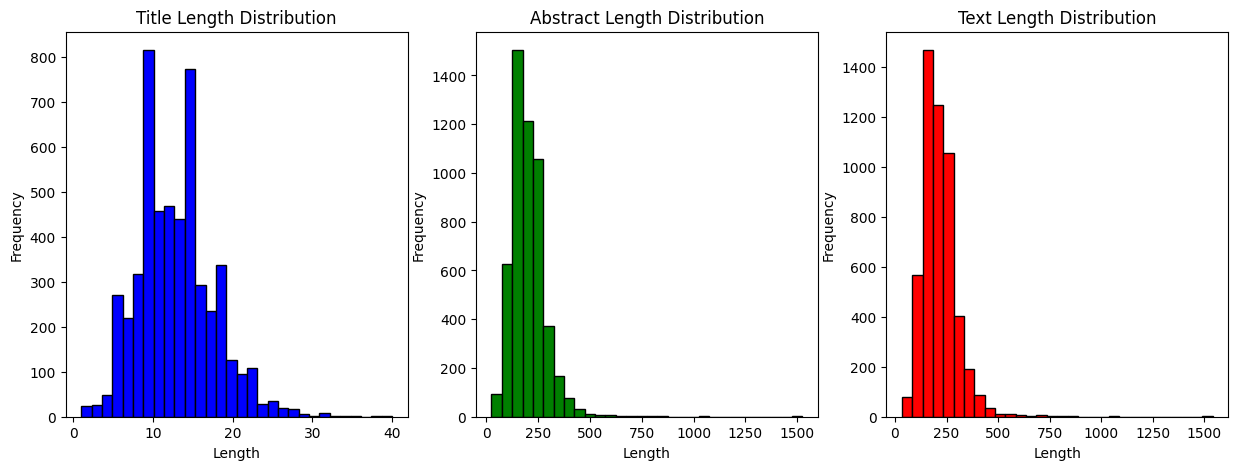

In [57]:
# On affiche les histogrammes des distributions de fréquences en fonction des longueurs
plt.figure(figsize=(15, 5))

# Plot pour title_length
plt.subplot(1, 3, 1)
plt.hist(df_corpus['title_length'], bins=30, color='blue', edgecolor='black')
plt.title('Title Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Plot pour abstract_length
plt.subplot(1, 3, 2)
plt.hist(df_corpus['abstract_length'], bins=30, color='green', edgecolor='black')
plt.title('Abstract Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Plot pour text_length
plt.subplot(1, 3, 3)
plt.hist(df_corpus['text_length'], bins=30, color='red', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

##### 1.2.8 Quelles remarques faites-vous sur les affirmations (claims) et les documents ? (1.5 points) 

En observant les maximums, les minimums et les moyennes, que remarquez-vous à propos des affirmations ('_claims_') ? À l'aide des graphiques générés, comparez également les documents.

•En observant les statistiques, on peut remarquer que :  
-Il y a des affirmations très courtes et d'autres assez longues.  
-En moyenne, un seul document est cité pour justifier une affirmation, ce qui n'est pas beaucoup.  

•En observant les histogrammes, on peut remarquer que :  
-La colonne title n'a pas l'air d'ajouter beaucoup d'information sur la colonne text car les distributions de text et d'abstract sont quasiment identiques.  

#### 1.3 Pré-traitement (6 points)
Les affirmations et résumés de texte de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de document (pouvant être "_title_", "_abstract_" ou la fusion des deux représentée par "_text_") qui justifie/contredit une affirmation. Vous devez donc implémenter une étape de pré-traitement des données.

##### 1.3.1 Implémentation de la fonction "_tokenize_sentence_" (1 point)

Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.

In [58]:
def tokenize_sentence(sentence):
    tokens = word_tokenize(sentence)
    return tokens

##### 1.3.2 Implémentation de la fonction "_tokenize_text_" (1 point)
Implémentez la fonction "_tokenize_text_" qui utilise "_tokenize_sentence_" pour faire la segmentation d'un texte (liste de phrases).

In [59]:
def tokenize_text(text):
    return [tokenize_sentence(sentence) for sentence in text]

##### 1.3.3 Implémentation de la fonction "_stem_tokens_" (1 point)

Implémentez la fonction "_stem_tokens_" qui prend une liste de jetons (tokens) en entrée et retourne une liste contenant leur forme racinisée (stems) en utilisant l'algorithme de racinisation PorterStemmer de la bibliothèque nltk.

In [60]:
def stem_tokens(tokens):
    stemmer = PorterStemmer() 
    stem_list = [] 
    for word in tokens:
        stem_token = stemmer.stem(word) # on prend la forme racinisée du mot
        stem_list.append(stem_token) 
    return stem_list

##### 1.3.4 Pré-traitement (2 points)

En utilisant vos précédentes fonctions, faites maintenant le pré-traitement des champs "_text_", "_title_" et "_abstract_" du dataframe "_df_corpus_" et "_claim_" du dataframe "_df_claims_" en suivant les étapes suivantes:
- conversion en minuscules
- segmentation (tokenization) des passages
- suppression des stop-words et ponctuation
- racinisation (stemming) des jetons

Nommez la liste des affirmations pré-traitées par "_claims_preprocessed_". Pour le corpus de documents considérez les ensembles de titres "_title_", de résumés "abstract" et la fusion des deux "_text_" et nommez les listes correspondantes par "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_" respectivement.

In [61]:
def preprocess_text(text):
    # Conversion en minuscule
    text = text.lower()
    # Tokenization
    tokens = tokenize_sentence(text)
    # Suppression des stop-words et ponctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    #Racinisation
    tokens = stem_tokens(tokens)
    
    return tokens

df_corpus['texts_preprocessed'] = df_corpus['text'].apply(preprocess_text)
df_corpus['abstracts_preprocessed'] = df_corpus['abstract'].apply(preprocess_text)
df_corpus['titles_preprocessed'] = df_corpus['title'].apply(preprocess_text)

df_claims['claims_preprocessed'] = df_claims['claim'].apply(preprocess_text)


##### 1.3.5 Jetons uniques (types) (1 point)

Affichez maintenant le nombre total de jetons dans tous les textes (_text_) et affirmations (_claim_) (en les considérant comme un seul corpus) après le pré-traitement. Puis, affichez le nombre de jetons uniques (types) dans les textes (_text_) et les affirmations (_claim_). 

In [62]:
texts_and_claims_corpus = pd.concat([df_corpus['texts_preprocessed'], df_claims['claims_preprocessed']])
tokens = [token for text_or_claim in texts_and_claims_corpus for token in text_or_claim]
types = set(tokens) # On transforme en set pour ne conserver que les jetons uniques

print(f"Nombre total de jetons: {len(tokens)}\n")
print(f"Nombre total de types: {len(types)}\n")

Nombre total de jetons: 742202

Nombre total de types: 45195



### 2. Représentation des affirmations et des documents  (45 points)

#### 2.1  Vocabulaire (15 points)

##### 2.1.1 Implémentation de la fonction "_get_vocab_" (3 points)

Implémentez la fonction "_get_vocab_" qui prend une liste de textes composés chacun d'une liste de jetons et retourne un dictionnaire dont les clés sont les jetons uniques et les valeurs sont leur fréquence dans l'ensemble des textes.

In [63]:
def get_vocab(texts_list):
    all_tokens = [token for text in texts_list for token in text]
    vocab = dict(Counter(all_tokens)) # On génère le dictionnaire avec Counter
    return vocab

##### 2.1.2 Implémentez la fonction "_show_top_N_types_" (3 points)

Implémentez la fonction "show_top_N_types" qui affiche les N jetons les plus fréquents à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_".

La fonction prend deux arguments: le dictionnaire "_dictionary_" et le paramètre "_N_". 

In [64]:
def show_top_N_types(dictionary, N):
    sorted_vocab = sorted(dictionary.items(), key=lambda item: item[1], reverse=True) # On trie le dictionnaire en fonction de la fréquence des jetons
    top_n_types = sorted_vocab[:N] # On garde seulement les N premiers
    print(f"Les {N} types les plus fréquents:")
    for type in top_n_types:
        print(type)

##### 2.1.3 Construction du vocabulaire (1 point)

Construisez maintenant le vocabulaire pour les affirmations et le corpus de documents à partir des listes "texts_preprocessed" et "claims_preprocessed". 

Ensuite affichez les 15 jetons les plus fréquents ainsi que leur fréquence.

In [65]:
vocab = get_vocab(pd.concat([df_corpus['texts_preprocessed'], df_claims['claims_preprocessed']])) # Construction du vocabulaire
show_top_N_types(vocab, 15) # Affichage des 15 types les plus fréquents et leur fréquence respective

Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)


Sortie attendue:

```Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)

##### 2.1.4 Implémentation de la fonction "_show_distribution_" (4 points)

Implémentez la fonction "__show_distribution__" qui permet de visualiser la distribution des fréquences des jetons à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_", en utilisant un graphique où l'axe des abscisses représente le rang d'un type (après un tri par ordre de fréquence décroissante) et l'axe des ordonnées représente sa fréquence sur une échelle logarithmique.  

Par exemple, le point (10000, 10) voudrait dire que le 10000ème mot le plus fréquent a une fréquence à peu prés egale à 10 dans le vocabulaire.

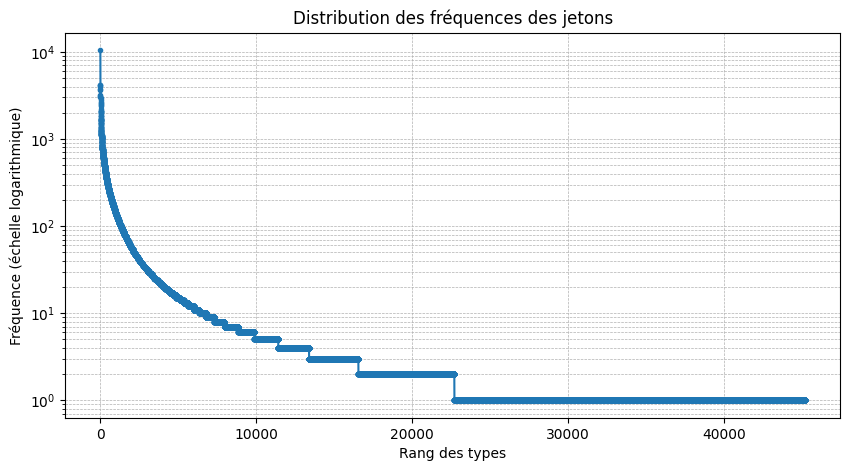

In [66]:
def show_distribution(vocab):
    # Trier les types par fréquence décroissante
    sorted_vocab = sorted(vocab.values(), reverse=True)
    
    # Obtenir les rangs et les fréquences
    ranks = np.arange(1, len(sorted_vocab) + 1)
    frequencies = np.array(sorted_vocab)
    
    # Afficher le graphique
    plt.figure(figsize=(10, 5))
    plt.plot(ranks, frequencies, marker='.', linestyle='-')
    plt.yscale('log')
    plt.xlabel('Rang des types')
    plt.ylabel('Fréquence (échelle logarithmique)')
    plt.title('Distribution des fréquences des jetons')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

show_distribution(vocab)

##### 2.1.5 Vérification de la loi de Zipf (4 points)

Afin de vérifier la loi de Zipf, donnez une estimation de la valeur de la constante k de cette loi définie comme suit: 

$$ f \approx \frac{k}{r^\alpha} $$ 

où $ f $ est la fréquence d'un mot, $ r $ est le rang de ce mot dans la liste triée par fréquence décroissante, et $ k $ est une constante. Etant données les fluctuations sur les valeurs de fréquence, vous pouvez utiliser la librairie ['powerlaw'](https://pypi.org/project/powerlaw/) conçue pour analyser et ajuster des distributions de loi de puissance aux données et qui peut être utile dans l'estimation de $ \alpha $.

Affichez la constante $ k $ trouvée, les fréquences réelles des mots avec celles qui sont prédites par la loi de Zipf.

Calculating best minimal value for power law fit
Constante K : 12131.745923002154


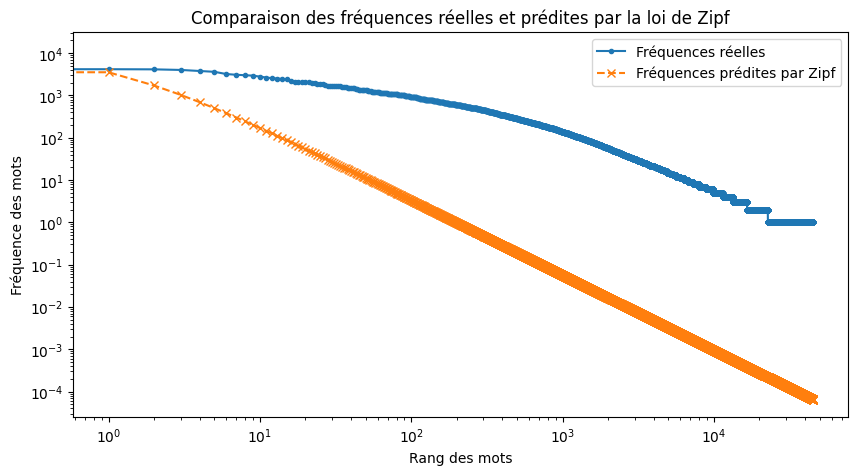

In [67]:
frequencies = sorted(vocab.values() , reverse=True)

data = powerlaw.Fit(frequencies) # On utilise powerlaw pour estimer alpha

r = np.arange(1, len(frequencies) + 1) # On calcule les rangs
r = r **(-data.power_law.alpha)

slope = np.polyfit(r, frequencies, 1)[0] # On récupère la pente qui correspond à K avec une regression linéaire

print(f'Constante K : {slope}')

predicted_freqs = [slope / ((i+1)**(data.power_law.alpha)) for i in range(len(frequencies))] # On calcule les fréquences prédites à partir de K

# Affichage du graphique
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, label='Fréquences réelles', marker='.', linestyle='-')
plt.loglog(predicted_freqs, label='Fréquences prédites par Zipf', marker='x', linestyle='--')
plt.xlabel('Rang des mots')
plt.ylabel('Fréquence des mots')
plt.title('Comparaison des fréquences réelles et prédites par la loi de Zipf')
plt.legend()
plt.show()

#### 2.2  Création d’un modèle sac de mots (10 points)

##### 2.2.1 Répresentation de texte (5 points)

En utilisant sklearn et à partir de vos données pré-traitées ("_claims_preprocessed_", "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_"), représentez chaque affirmation (_claim_) et document avec le vocabulaire créé 'précédemment dans la variables "_claims_preprocessed_joined", "_titles_preprocessed_joined_", "_abstract_preprocessed_joined_" et "_texts_preprocessed_joined_". Cela veut dire que tout jeton qui n'est pas dans le vocabulaire doit être enlevé dans le document et l'affirmation. Faites cela pour les trois possibilités de représentation de document: "_title_", "_abstract_" et "_text_".

In [68]:
def exclude_tokens(all_tokens, vocab):
    return [[token for token in list_of_tokens if token in vocab.keys()] for list_of_tokens in all_tokens] # On ne garde que les tokens du vocabulaire

# On filtre les jetons avec le vocabulaire
claims_preprocessed_filtered = exclude_tokens(df_claims['claims_preprocessed'], vocab) 
titles_preprocessed_filtered = exclude_tokens(df_corpus['titles_preprocessed'], vocab)
abstracts_preprocessed_filtered = exclude_tokens(df_corpus['abstracts_preprocessed'], vocab)
texts_preprocessed_filtered = exclude_tokens(df_corpus['texts_preprocessed'], vocab)

claims_preprocessed_joined = [' '.join(tokens) for tokens in claims_preprocessed_filtered] # On utilise join pour obtenir une liste d'affirmations prétraitées

titles_preprocessed_joined = [' '.join(tokens) for tokens in titles_preprocessed_filtered] # On utilise join pour obtenir une liste de documents titles prétraités

abstracts_preprocessed_joined = [' '.join(tokens) for tokens in abstracts_preprocessed_filtered] # On utilise join pour obtenir une liste de documents abstracts prétraités

texts_preprocessed_joined = [' '.join(tokens) for tokens in texts_preprocessed_filtered] # On utilise join pour obtenir une liste de documents texts prétraités

##### 2.2.2 Pondération (4 points)

En utilisant un modèle sac de mots basé sur des unigrammes et des bigrammes, créez une représentation vectorielle de vos documents (titles, abstracts, texts) et de vos affirmations (claims) avec TF-IDF en utilisant le TfidfVectorizer de sklearn. 

In [69]:
# Initilisation de TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Construction du vocabulaire avec les affirmations et les textes
vectorizer.fit(claims_preprocessed_joined + texts_preprocessed_joined) 

# Obtention des représentation vectorielles des affirmations et des documents
claims_tfidf = vectorizer.transform(claims_preprocessed_joined) 
titles_tfidf = vectorizer.transform(titles_preprocessed_joined)
abstracts_tfidf = vectorizer.transform(abstracts_preprocessed_joined)
texts_tfidf = vectorizer.transform(texts_preprocessed_joined)

##### 2.2.3 Affichage (1 point)

Affichez les dimensions (shape) de vos corpus (claims, text, title, abstract) après vectorisation

In [70]:
# Affichage des dimensions de la matrice TF-IDF pour les affirmations
print(claims_tfidf.shape)

(809, 473643)


Sortie attendue pour "_claims_"
```
(809, 473643)
```

In [71]:
# Affichage des dimensions de la matrice TF-IDF pour les documents texts
print(texts_tfidf.shape)

(5183, 473643)


Sortie attendue pour "_texts_"
```
(5183, 473643)
```

In [72]:
# Affichage des dimensions de la matrice TF-IDF pour les documents titles
print(titles_tfidf.shape)

(5183, 473643)


Sortie attendue pour "_titles_"
```
(5183, 473643)
```

In [73]:
# Affichage des dimensions de la matrice TF-IDF pour les documents abstracts
print(abstracts_tfidf.shape)

(5183, 473643)


Sortie attendue pour abstracts
```
(5183, 473643)

#### 2.3 Pertinence d'un document (20 points)

Maintenant que vous avez une représentation de vos affirmations "_claims_" et documents ("_texts_", "_titles_", "_abstracts_"), il faut être capable de déterminer quel document sera le plus pertinent pour une affirmation donnée.

##### 2.3.1 Implémentation de "_eval_similarity_" (3 points)

Implémentez la fonction "_eval_similarity_" pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document. La fonction prend une liste d'affirmations et une liste de documents et retourne une matrice où chaque ligne représente une affirmation et chaque colonne représente un document ("title", "abstract" ou "text") et les valeurs sont les similarités cosinus entre une affirmation et un document.

In [74]:
def eval_similarity(claims_tfidf, docs_tfidf):
    return cosine_similarity(claims_tfidf, docs_tfidf) # On retourne la matrice de similarité

##### 2.3.2 Implémentation de la fonction "_rank_texts_" (2 points)

Implémentez la fonction "_rank_texts_", qui, au moyen de la précédente (_eval_similarity_), retourne le top-N (N=1,3,5) des documents pertinents pour une affirmation donnée (N est un paramètre). Ces documents devront être ordonnés du plus pertinent au moins pertinent. Idéalement, le document à la position 1 sera celui qui contient la preuve (ou justification) de l'affirmation. Il faudra retourner non pas les indices des documents dans le dataframe mais plutôt leur identifiants au niveau de la colonne "_doc_id_".

In [75]:
def rank_texts(claims_tfidf, docs_tfidf, N=5):
    
    # Calcul de la matrice de similarité entre les affirmations et les documents
    similarity_matrix = eval_similarity(claims_tfidf, docs_tfidf)
    
    top_n_docs = []

    for i, similarities in enumerate(similarity_matrix): # pour chaque ligne (donc pour chaque affirmation)
        
        # Indices des N documents les plus similaires, triés par pertinence décroissante
        top_n_indices = similarities.argsort()[::-1][:N]
        
        # Identifiants des documents correspondants à ces indices
        top_n_doc_ids = [df_corpus.iloc[id]['doc_id'] for id in top_n_indices]
        
        top_n_docs.append(top_n_doc_ids)
    
    return top_n_docs

##### 2.3.3 Préparation des dataframes de réponses (1 point) 

Vous allez écrire la fonction "prepare_results_df" qui crée les dataframes qui vont contenir les résultats de la recherche de documents pertinents pour les affirmations.

La fonction "prepare_results_df" prend les arguments suivants:

- '_df_': le dataframe original nommé '_df_claims_' à partir duquel on crée les autres, 
- '_columns_to_drop_': les colonnes à supprimer 
- '_column_to_rename_': le nom de la colonne de référence dans le dataframe original qui sera renommée "gold standard passage"

et effectue les opérations suivantes:

1. Créer un nouveau dataframe à partir de "_df_claims_" en supprimant toutes les colonnes sauf "cited_doc_ids".
2. Renommer la colonne "cited_doc_ids" en "gold standard passage".
3. Ajouter les colonnes "top_1", "top_3", et "top_5" au dataframe, 
en les initialisant avec des chaînes de zéros séparés par des points-
virgules, correspondant respectivement à des configurations de 1, 3, et 
5 zéros pour toutes les lignes.

Vous utiliserez ensuite cette fonction pour créer les dataframes "results_titles_df", "results_abstracts_df" et "results_texts_df", qui seront destinés à contenir les résultats de recherche de documents pour "title", "abstract" et "text" respectivement.

In [76]:
def prepare_results_df(df, columns_to_drop, column_to_rename):

    # Supprimer les colonnes columns_to_drop
    df_results = df.drop(columns=columns_to_drop).copy()

    # Renommer la colonne column_to_rename
    df_results.rename(columns={column_to_rename: 'gold standard passage'}, inplace=True)
    
    # Ajouter les colonnes top_1, top_3 et top_5
    df_results['top_1'] = '0'
    df_results['top_3'] = '0;0;0'
    df_results['top_5'] = '0;0;0;0;0'
    
    return df_results

> Sortie attendue pour chaque dataframe préparé
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>gold standard passage</th>
      <th>top_1</th>
      <th>top_3</th>
      <th>top_5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>[31715818]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>[13734012]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>[22942787]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
  </tbody>
</table>
</div>

##### 2.3.4 Implémentation de la fonction "_fill_results_" (2 points)

Vous devez maintenant implémenter la fonction "_fill_results_" qui remplit les dataframes préparés dans l'étape précédente en utilisant les resultats de recherche de document.
Cette fonction prend les arguments suivant: 
- "_results_" : matrice contenant les valeurs de similarite des affirmations et des documents
- "_results_texts_df_" : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" où doivent être mis les top-n documents les plus pertinents.

Les deux arguments contiennent le même nombre d'éléments et pour le même indice, font référence à la même affirmation.

In [77]:
def fill_results(results, results_texts_df):
    for i, top_n_doc_ids in enumerate(results):  # On itère sur chaque ligne (donc chaque affirmation)

        top_n_doc_ids_str = [str(doc_id) for doc_id in top_n_doc_ids] # Conversion en string

        # Remplissage des colonnes top_1, top_3, et top_5
        results_texts_df.at[i, 'top_1'] = top_n_doc_ids_str[0]
        results_texts_df.at[i, 'top_3'] = ';'.join(top_n_doc_ids_str[:3])
        results_texts_df.at[i, 'top_5'] = ';'.join(top_n_doc_ids_str[:5])
    return results_texts_df

##### 2.3.5 Exécution des fonctions "_rank_texts_" et fill_results(2 points)

Exécutez maintenant votre fonction "_rank_texts_" sur toutes les affirmations (claims) et toutes les représentations de documents (title, abstract, text) en mettant les résultats dans les variables "results_texts", "results_titles" et "results_abstracts". Ensuite appelez la fonction "_fill_results_" qui remplit les dataframes "_results_titles_df_", "_results_abstracts_df_", et "_results_texts_df_" contenant les résultats de recheche de documents.

In [78]:
# Préparation des DataFrames résultats avec appels de la fonction prepare_results_df
results_titles_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_abstracts_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_texts_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')

# Appel de la fonction rank_texts
results_texts = rank_texts(claims_tfidf, texts_tfidf)
results_titles = rank_texts(claims_tfidf, titles_tfidf)
results_abstracts = rank_texts(claims_tfidf, abstracts_tfidf)

# Remplissage des DataFrames résultats avec appel de la fonction fill_results
fill_results(results_texts, results_texts_df)
fill_results(results_titles, results_titles_df)
fill_results(results_abstracts, results_abstracts_df)

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10608397,10608397;10607877;21257564,10608397;10607877;21257564;994800;14827874
1,2,[13734012],13734012,13734012;17333231;13770184,13734012;17333231;13770184;42240424;3716075
2,4,[22942787],7165938,7165938;1387104;52188256,7165938;1387104;52188256;520579;43334921
3,6,[2613775],23117378,23117378;21050357;2613775,23117378;21050357;2613775;20240998;35521287
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;25182647;32787042
...,...,...,...,...,...
804,1403,"[33370, 38355793]",33370,33370;38355793;7986878,33370;38355793;7986878;40412980;45764440
805,1404,"[33370, 38355793]",38355793,38355793;33370;7986878,38355793;33370;7986878;40412980;45764440
806,1405,[10504681],20402596,20402596;38675228;10504681,20402596;38675228;10504681;5849439;19950357
807,1406,[2617858],2617858,2617858;4465762;4857085,2617858;4465762;4857085;13963620;10577574


##### 2.3.6 Enregistrement des dataframes 

On enregistre les dataframes dans des fichiers .csv.

In [79]:
#Enregistrement des DataFrames

results_texts_df.to_csv('results_texts.csv', index=False, sep='\t')
results_titles_df.to_csv('results_titles.csv', index=False, sep='\t')
results_abstracts_df.to_csv('results_abstracts.csv', index=False, sep='\t')

##### 2.3.7 Implémentation de la fonction "_show_top_n_passages_" (3 points)

Vous devez maintenant implémenter une fonction "_show_top_n_passages_" qui affiche le top-n ainsi que le texte (document) attendu pour une affirmation donnée. Ici on considère que document est representé par "_text_" donc la fusion du titre ("_title_") et du résumé ("_abstract_")

In [80]:
def show_top_n_passages(claim_id, N):
    # Trouver l'indice de l'affirmation dans df_claims
    claim_index = df_claims.index[df_claims['id'] == claim_id].tolist()
    
    if not claim_index:
        print(f"Aucun ID d'affirmation trouvé pour {claim_id}.")
        return
    
    claim_index = claim_index[0]
    
    # Accéder à la ligne correspondante dans results_texts_df
    top_n_doc_ids = results_texts_df.at[claim_index, f'top_{N}'].split(';')
    
    # Afficher les top-N documents
    print(f"Top-{N} documents pour l'affirmation ID {claim_id}:")
    
    for rank, doc_id in enumerate(top_n_doc_ids, start=1):
        print(f"Rang {rank}: Document ID {doc_id}")

##### 2.3.8 Affichage (1 point)

Appliquez cette fonction sur l'affirmation ayant pour identifiant 211 et affichez le top-5 des documents les plus pertinents retrouvés.

In [81]:
show_top_n_passages(211, 5)

Top-5 documents pour l'affirmation ID 211:
Rang 1: Document ID 14019636
Rang 2: Document ID 44737533
Rang 3: Document ID 6290112
Rang 4: Document ID 20261352
Rang 5: Document ID 5137019


##### 2.3.9 Évaluation (3 points)

Vous devez maintenant implémenter la fonction "_evaluate_" qui, à partir des colonnes *Gold standard passage* et de vos top-N respectifs, calcule la précision top-N (N=1,3,5) sur l’ensemble de données en paramètre et l’affiche. 

Cette précision connue sous le nom "precision at k (precision@k)" se calcule de la manière suivante:


$$
\text{precision@k} = \frac{\text{nombre d'éléments corrects}}{\text{nombre total d'éléments k retrouvés}}
$$


Veillez à ce que la fonction soit générique. 

In [82]:
def evaluate(results_df, gold_standard_col_name='gold standard passage', top_n_cols_names=None):

    if top_n_cols_names is None:
        top_n_cols_names = ['top_1', 'top_3', 'top_5']

    # Initialiser les compteurs pour les précisions
    precision_at_1 = 0
    precision_at_3 = 0
    precision_at_5 = 0

    # Nombre total de documents pour le calcul de la précision
    total_count = len(results_df)
    
    for _, row in results_df.iterrows():
        # Récupérer les listes de documents pertinents et les résultats des top-N
        gold_standard_passage = set(map(str, row[gold_standard_col_name]))
        top_1_docs = set(row[top_n_cols_names[0]].split(';'))
        top_3_docs = set(row[top_n_cols_names[1]].split(';'))
        top_5_docs = set(row[top_n_cols_names[2]].split(';'))

        # Calculer le nombre de documents corrects en faisant une intersection des top-N avec les documents cités
        correct_at_1 = len(gold_standard_passage.intersection(top_1_docs))
        correct_at_3 = len(gold_standard_passage.intersection(top_3_docs))
        correct_at_5 = len(gold_standard_passage.intersection(top_5_docs))

        precision_at_1 += correct_at_1
        precision_at_3 += correct_at_3
        precision_at_5 += correct_at_5

    # Calculer la précision
    precision_at_1 = precision_at_1 / total_count
    precision_at_3 = precision_at_3 / (3*total_count)
    precision_at_5 = precision_at_5 / (5*total_count)

    # Afficher les résultats
    print(f"Précision @1: {precision_at_1:.4f}")
    print(f"Précision @3: {precision_at_3:.4f}")
    print(f"Précision @5: {precision_at_5:.4f}")

    return precision_at_1, precision_at_3, precision_at_5

##### 2.3.10 Affichage (1 point)

Appliquez cette fonction pour calculer la précision des documents retrouvés en utilisant les titres ("_title_"), les résumés ("_abstract_") et la fusion des deux ("_text_").

In [83]:
print(f"Précision using titles:")
precisions_titles = evaluate(results_titles_df)

print(f"Précision using abstracts:")
precisions_abstracts = evaluate(results_abstracts_df)

print(f"Précision using texts:")
precisions_texts = evaluate(results_texts_df)

Précision using titles:
Précision @1: 0.3226
Précision @3: 0.1636
Précision @5: 0.1117
Précision using abstracts:
Précision @1: 0.4660
Précision @3: 0.2167
Précision @5: 0.1439
Précision using texts:
Précision @1: 0.4870
Précision @3: 0.2254
Précision @5: 0.1520


##### 2.3.11 Graphique (2 points)

Tracez un graphique des valeurs de précisions des documents retrouvés ("__title__", "__abstract__", "__text__") pour différents N (1,3,5).

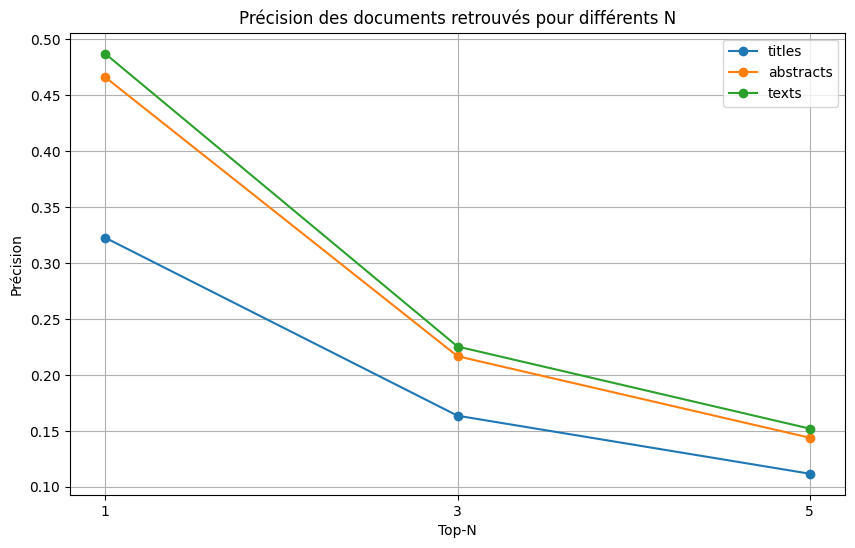

In [84]:
documents_types = ['titles', 'abstracts', 'texts']
N_values = [1, 3, 5]

precisions = {
    'titles': precisions_titles,
    'abstracts': precisions_abstracts,
    'texts': precisions_texts
}

# Afficher le graphique
plt.figure(figsize=(10, 6))

for document_type in documents_types:
    plt.plot(N_values, precisions[document_type], marker='o', label=document_type)

plt.title('Précision des documents retrouvés pour différents N')
plt.xlabel('Top-N')
plt.ylabel('Précision')
plt.xticks(N_values)
plt.legend()
plt.grid(True)

### 3 Amélioration avec BM25 (20 points)

BM25 (Best Matching 25) est un algorithme de recherche utilisé pour évaluer la pertinence des documents par rapport à une requête. Basé sur le modèle de récupération d'informations probabilistes, BM25 calcule un score de pertinence en tenant compte de la fréquence des termes de la requête dans chaque document et dans le corpus global mais aussi de la longueur des documents. 

BM25 est pertinent pour la recherche d'information car il offre un bon équilibre entre précision et rappel, il gère efficacement de grandes collections de documents et permet des ajustements pour différents types de corpus. Il est largement utilisé dans les moteurs de recherche et les systèmes de recommandation.

Dans cette partie on vous demande de la tester au moyen de la librairie rank_bm25 pour cette tâche de recherche de texte qui justifie ou contredit une affirmation donnée. Vous allez utiliser le corpus et les affirmations et procéder comme indiqué dans la suite.

##### 3.1 Initialisation du modèle BM25 (3 points)
Réutilisez les variables "claims_preprocessed_joined", "texts_preprocessed_joined", "titles_preprocessed_joined" et "abstract_preprocessed_joined" définies à la question `2.2.1` pour initialiser les modèles BM25 pour les documents ("__titles__", "__abstracts__" et "__text__"). Il faudra transformer chaque séquence (dont les jetons étaient joints pour former une seule chaîne) en une liste de jetons. Vous utiliserez la classe "_BM250kapi_" à ce niveau. 

In [85]:
tokenized_titles_preprocessed_joined = [text.split() for text in titles_preprocessed_joined]
tokenized_abstracts_preprocessed_joined = [text.split() for text in abstracts_preprocessed_joined]
tokenized_texts_preprocessed_joined = [text.split() for text in texts_preprocessed_joined]

# Initialisation des modèles BM25
bm25_titles = BM25Okapi(tokenized_titles_preprocessed_joined)
bm25_abstracts = BM25Okapi(tokenized_abstracts_preprocessed_joined)
bm25_texts = BM25Okapi(tokenized_texts_preprocessed_joined)

##### 3.2 Utilisation du modèle BM25 (5 points)

Retrouvez les identifiants des documents pour les cinq meilleures correspondances de "_title_", de "_abstract_" et de "_text_" en utilisant le score BM25 pour chaque affirmation (claim) traitée, et mettez à jour les résultats avec les identifiants de documents correspondants.

In [86]:
def rank_texts_bm25(claims, bm25, N=5):
    top_n_docs = []
    for claim in claims:
        # Obtenir les scores BM25
        scores = bm25.get_scores(claim.split())

        # Indices des N documents les plus similaires, triés par pertinence décroissante
        top_n_indices = np.argsort(scores)[::-1][:N]

        # Identifiants des documents correspondants à ces indices
        top_n_doc_ids = [df_corpus.iloc[id]['doc_id'] for id in top_n_indices]
        top_n_docs.append(top_n_doc_ids)
    return top_n_docs

# Appel de la fonction rank_texts_bm25
results_titles_bm25 = rank_texts_bm25(claims_preprocessed_joined, bm25_titles)
results_abstracts_bm25 = rank_texts_bm25(claims_preprocessed_joined, bm25_abstracts)
results_texts_bm25 = rank_texts_bm25(claims_preprocessed_joined, bm25_texts)

##### 3.3 Affichage des performances (4 points)

Affichez les résultats des performances BM25 pour les configurations Top1, Top3 et Top5 avec "_title_", "_asbtract_" et "_text_".

In [87]:
# Préparation des DataFrames résultats avec appels de la fonction prepare_results_df
results_titles_bm25_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_abstracts_bm25_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_texts_bm25_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')

# Remplissage des DataFrames résultats avec appel de la fonction fill_results
fill_results(results_titles_bm25, results_titles_bm25_df)
fill_results(results_abstracts_bm25, results_abstracts_bm25_df)
fill_results(results_texts_bm25, results_texts_bm25_df)

results_titles_bm25_df.to_csv('results_titles_bm25.csv', index=False, sep='\t')
results_abstracts_bm25_df.to_csv('results_abstracts_bm25.csv', index=False, sep='\t')
results_texts_bm25_df.to_csv('results_texts_bm25.csv', index=False, sep='\t')

# Affichage des précisions@k
print(f"Précision using titles:")
precisions_titles_bm25 = evaluate(results_titles_bm25_df)

print(f"Précision using abstracts:")
precisions_abstracts_bm25 = evaluate(results_abstracts_bm25_df)

print(f"Précision using texts:")
precisions_texts_bm25 = evaluate(results_texts_bm25_df)

Précision using titles:
Précision @1: 0.3251
Précision @3: 0.1471
Précision @5: 0.0991
Précision using abstracts:
Précision @1: 0.5538
Précision @3: 0.2344
Précision @5: 0.1567
Précision using texts:
Précision @1: 0.5674
Précision @3: 0.2394
Précision @5: 0.1582


##### 3.4 Graphique (4 points)

Dans un même graphique, affichez les performances pour les deux modèles (TF-IDF et BM25) dans la recherche des documents (text, title et abstract) pour les affirmations.

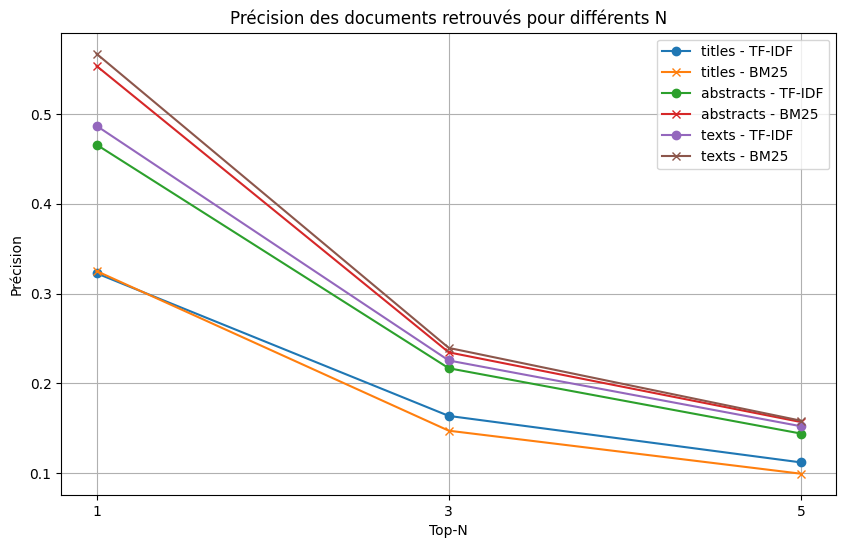

In [88]:
documents_types = ['titles', 'abstracts', 'texts']
N_values = [1, 3, 5]

precisions_bm25 = {
    'titles': precisions_titles_bm25,
    'abstracts': precisions_abstracts_bm25,
    'texts': precisions_texts_bm25
}

precisions_tfidf = {
    'titles': precisions_titles,
    'abstracts': precisions_abstracts,
    'texts': precisions_texts
}

# Afficher le graphique
plt.figure(figsize=(10, 6))

for document_type in documents_types:
    plt.plot(N_values, precisions_tfidf[document_type], marker='o', label=f'{document_type} - TF-IDF')
    plt.plot(N_values, precisions_bm25[document_type], marker='x', label=f'{document_type} - BM25')

plt.title('Précision des documents retrouvés pour différents N')
plt.xlabel('Top-N')
plt.ylabel('Précision')
plt.xticks(N_values)
plt.legend()
plt.grid(True)

plt.show()

##### 3.5 Observation (4 points)

Par rapport à vos résultats avec TF-IDF, observez-vous une amélioration ou une détérioration des performances, qu'est ce qui explique cela ? (Donnez au moins trois justifications)

On remarque globalement une amélioration des performances de BM25 par rapport à TF-IDF. Cela est en parti dû au fait que BM25 considère un facteur que TF-IDF ignore, l'impact de la longueur des documents. En incluant ce facteur dans le calcul du score, on pénalise les documents longs en donnant un certain avantage aux documents plus courts. Ceci est fait parce que le fait qu'un terme document soit long (et présente donc une fréquence élevée pour un terme donné) ne signifie pas que ce document est plus pertinent qu'un document plus court dont la fréquence d'un terme est plus basse. Par ailleurs, BM25 prend également en compte la saturation de la fréquence des termes. Contrairement à TF-IDF qui continue d'augmenter proportionnellement à la fréquence d'un terme dans un document, BM25 applique une fonction de saturation à la fréquence des termes. En d'autres mots, si un mot apparaît de nombreuses fois dans un document, son importance ne continue pas à croître de manière linéaire, mais tend à se stabiliser. Cette approche permet d'éviter qu'un document soit indûment favorisé simplement parce qu'il contient un terme plusieurs fois, ce qui améliore la pertinence des résultats une fois de plus. Finalement, BM25 introduit des paramètres ajustables comme k1 (contrôle l'importance de la fréquence d'un terme) et b (contrôle l'importance de la normalisation par la longueur du document). Ces paramètres permettent d'affiner le comportement du modèle en fonction des spécificités du corpus, ce qui n'est pas possible avec TF-IDF, qui reste plus rigide dans sa formule. Cette flexibilité permet d'obtenir des résultats plus adaptés à divers types de corpus, améliorant la précision de la recherche.

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
